## <center><ins>Trabajo Práctico 1: Reservas de hotel</ins></center>
#### <center>*Checkpoint 4: Redes Neuronales*</center>
##### <center>75.06 / 95.58 Organización de Datos - FIUBA</center>
##### <center>Ing. Rodríguez - 1°C 2023</center>
---
#### <center>**Grupo 31 - "Datazo":**</center>
<center> Michael Mena - 102685</center>
<center>Pablo Brocca - 104256</center>
<center>Diego Kisinovsky - 106203</center>

---
---

## Carga de datos y librerías

##### Imports:

In [193]:
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from IPython.display import Image
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


# Modelos y métricas
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import GridSearchCV

# Preprocesamiento
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

# Manejo de modelos
from pickle import dump
from pickle import load

# Configuración de warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# PCA
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Modelos
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras import optimizers
from keras.callbacks import EarlyStopping
import keras.backend as K
# from scikeras.wrappers import KerasClassifier

# Configuración de tensorflow, asegurando reproducibilidad
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


##### Lectura del dataset preprocesado:

In [161]:
hotel_train = pd.read_csv('./dataset/hotels_train_preprocesado.csv')

---

## Armado y entrenamiento de la Red Neuronal

### Preparación de features:

In [162]:
features = hotel_train.drop(['is_canceled'],axis=1).columns
          
target = 'is_canceled'

features.tolist()

['lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_day_of_month',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'stays_in_nights',
 'total_of_guests',
 'room_type_unchanged',
 'country_encoded',
 'customer_type_Group',
 'customer_type_Transient',
 'customer_type_Transient-Party',
 'deposit_type_Non Refund',
 'deposit_type_Refundable',
 'hotel_Resort Hotel',
 'distribution_channel_Direct',
 'distribution_channel_GDS',
 'distribution_channel_TA/TO',
 'distribution_channel_Undefined',
 'market_segment_Complementary',
 'market_segment_Corporate',
 'market_segment_Direct',
 'market_segment_Groups',
 'market_segment_Offline TA/TO',
 'market_segment_Online TA',
 'market_segment_Undefined',
 'meal_FB',
 'meal_HB',
 'meal_SC',
 'meal_Undefined']

In [163]:
cols_categorical = ['room_type_unchanged',
                    'country_encoded',
                   'customer_type_Group',
                   'customer_type_Transient',
                   'customer_type_Transient-Party',
                   'deposit_type_Non Refund',
                   'deposit_type_Refundable',
                   'hotel_Resort Hotel',
                   'distribution_channel_Direct',
                   'distribution_channel_GDS',
                   'distribution_channel_TA/TO',
                   'distribution_channel_Undefined',
                   'market_segment_Complementary',
                   'market_segment_Corporate',
                   'market_segment_Direct',
                   'market_segment_Groups',
                   'market_segment_Offline TA/TO',
                   'market_segment_Online TA',
                   'market_segment_Undefined',
                   'meal_FB',
                   'meal_HB',
                   'meal_SC',
                   'meal_Undefined']

In [164]:
cols_to_normalize =[col for col in hotel_train.columns if col not in cols_categorical]

In [165]:
cols_to_normalize.remove('is_canceled')
cols_to_normalize

['lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_day_of_month',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'stays_in_nights',
 'total_of_guests']

### Definicion de funciones auxiliares:

In [166]:
# Esta metrica no esta implementada en keras, por lo que la definimos
def f1_score(y_true, y_pred):
    # Cálculo de la métrica F1-score
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    precision = tp / (K.sum(K.round(K.clip(y_pred, 0, 1))) + K.epsilon())
    recall = tp / (K.sum(K.round(K.clip(y_true, 0, 1))) + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return f1

# Registramos la métrica en keras
keras.utils.get_custom_objects()['f1_score'] = f1_score

### Train-Test Split:

In [167]:
# Separamos un 20% de los datos para test
x_train, x_test, y_train, y_test = train_test_split(hotel_train[features].values, 
                                                    hotel_train[target].values, 
                                                    test_size=0.2,    
                                                    random_state=42,  
                                                    stratify=hotel_train[target].values) 

# Verificamos cantidad de datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

# Verificamos como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 48682
# Datos Prueba: 12171
% Positivos Entrenamiento: 50.433
% Positivos Prueba: 50.431


### Estandarización de datos:

#### Versión estandarizada con: $\frac{x_i - mean(x)}{stdev(x)}$

In [168]:
# Separación de datos para normalizar
x_train_to_norm = pd.DataFrame(x_train, columns=features).drop(cols_categorical, axis=1)
x_test_to_norm = pd.DataFrame(x_test, columns=features).drop(cols_categorical, axis=1)

# Separación de datos categoricos
x_train_encoded = pd.DataFrame(x_train, columns=features).drop(cols_to_normalize, axis=1)
x_test_encoded = pd.DataFrame(x_test, columns=features).drop(cols_to_normalize, axis=1)

In [169]:
# Aplicamos la transformación de escalado de características
stand_scaler = StandardScaler()
x_train_norm_scaled = stand_scaler.fit_transform(x_train_to_norm)
x_test_norm_scaled = stand_scaler.transform(x_test_to_norm)

# Convertir las matrices escaladas nuevamente en DataFrames
x_train_numeric = pd.DataFrame(x_train_norm_scaled, columns=cols_to_normalize)
x_test_numeric = pd.DataFrame(x_test_norm_scaled, columns=cols_to_normalize)

# Alternativa 1 : Concatenar los datos
x_train_norm = pd.concat([x_train_numeric, x_train_encoded], axis=1)
x_test_norm = pd.concat([x_test_numeric, x_test_encoded], axis=1)

# Alternativa 2 : Usar listas (Necesario para el modelo con capas para categoricos y numericos)
# x_train_norm = [x_train_encoded, x_train_numeric]
# x_test_norm = [x_test_encoded, x_test_numeric]

### Armado Modelo:

Se arma un modulo discriminando entre variables categóricas y numéricas, para poder aplicar distintos preprocesamientos a cada una.


In [170]:
# Calcula la cantidad de clases
cant_clases = 1 # Como es un problema de clasificación binaria, la cantidad de clases es 1

# Calcula la cantidad de features
d_in = len(features)
d_in_combined = len(x_train_norm.columns)

# Definir las capas de entrada
input_combined = keras.Input(shape=(d_in_combined,))

# Capas para las columnas codificadas (categóricas)
x = keras.layers.Dense(48, activation='relu', kernel_initializer='uniform')(input_combined) # kernel_regularizer=keras.regularizers.l2(0.1)
x = keras.layers.Dense(48, activation='relu', kernel_initializer='uniform')(x)
encoded_outputs = keras.layers.Dense(cant_clases, activation='relu')(x)

# Capas para las columnas numéricas (opcional)
y = keras.layers.Dense(32, activation='relu', kernel_initializer='uniform')(input_combined)
y = keras.layers.Dense(32, activation='relu', kernel_initializer='uniform')(y)

# Combinar las salidas de las capas codificadas y numéricas
combined = keras.layers.concatenate([encoded_outputs, y])

# Capa de salida
output = keras.layers.Dense(cant_clases, activation='sigmoid')(combined)

# Crear el modelo
model_rn = keras.Model(inputs=input_combined, outputs=output)
model_rn.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 dense_36 (Dense)               (None, 48)           1872        ['input_7[0][0]']                
                                                                                                  
 dense_37 (Dense)               (None, 48)           2352        ['dense_36[0][0]']               
                                                                                                  
 dense_39 (Dense)               (None, 32)           1248        ['input_7[0][0]']                
                                                                                            

Con pocas neuronas (32) los resultados no son consistentes, a veces se obtienen buenos resultados y otras veces no. Esto se debe a que la red no tiene la capacidad de aprender la complejidad del problema. A medida que se aumenta la cantidad de neuronas, la red puede aprender más complejidad y los resultados son más consistentes.

### Entrenamiento:

In [171]:
# Configurar el optimizador
optimizer = optimizers.Adadelta(learning_rate=0.1) # Alternativas: Adamax (Más lento), otros No convergen

# Compilar el modelo
model_rn.compile(optimizer=optimizer,
                 loss='binary_crossentropy', # sparse_categorical_crossentropy, categorical_crossentropy
                 metrics=['binary_accuracy', 'AUC', 'f1_score'])

cant_epochs = 400

# Configurar el callback de Early Stopping (detiene el entrenamiento cuando no hay mejoras en la métrica de validación)
early_stopping = EarlyStopping(monitor='f1_score', 
                               patience=25, mode='max', # mode='min' para loss (minimizar)
                               restore_best_weights=True, 
                               min_delta=0.00005)

# Entrenar el modelo
history_model_rn = model_rn.fit(x_train_norm, y_train,
                                epochs=cant_epochs, batch_size=25, # batch_size separa los datos en lotes
                                #validation_data=([x_test_encoded, x_test_numeric], y_test),
                                verbose=1,
                                callbacks=[early_stopping]
                                )

Epoch 1/400
1948/1948 [==============================] - 4s 1ms/step - loss: 0.5129 - binary_accuracy: 0.7413 - auc: 0.8235 - f1_score: 0.6928
Epoch 2/400
1948/1948 [==============================] - 3s 1ms/step - loss: 0.4115 - binary_accuracy: 0.7991 - auc: 0.8883 - f1_score: 0.7883
Epoch 3/400
1948/1948 [==============================] - 3s 1ms/step - loss: 0.3885 - binary_accuracy: 0.8110 - auc: 0.9020 - f1_score: 0.8024
Epoch 4/400
1948/1948 [==============================] - 3s 1ms/step - loss: 0.3784 - binary_accuracy: 0.8178 - auc: 0.9074 - f1_score: 0.8093
Epoch 5/400
1948/1948 [==============================] - 3s 1ms/step - loss: 0.3714 - binary_accuracy: 0.8214 - auc: 0.9111 - f1_score: 0.8140
Epoch 6/400
1948/1948 [==============================] - 3s 1ms/step - loss: 0.3657 - binary_accuracy: 0.8237 - auc: 0.9141 - f1_score: 0.8179
Epoch 7/400
1948/1948 [==============================] - 3s 1ms/step - loss: 0.3606 - binary_accuracy: 0.8270 - auc: 0.9167 - f1_score: 0.8204

## Análisis de la Red Neuronal

In [172]:
print('Accuracy: {:.2f}%'.format(model_rn.evaluate(x_test_norm, y_test)[1]*100))
print('AUC: {:.2f}%'.format(roc_auc_score(y_test, model_rn.predict(x_test_norm))*100))

381/381 [==============================] - 1s 1ms/step - loss: 0.3243 - binary_accuracy: 0.8560 - auc: 0.9380 - f1_score: 0.8521
Accuracy: 85.60%
381/381 [==============================] - 0s 823us/step
AUC: 93.85%


381/381 [==============================] - 0s 1ms/step


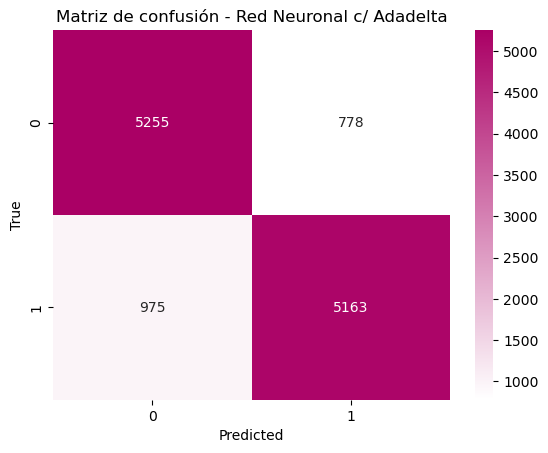

In [198]:
# Obtener la matriz de confusión
y_pred = model_rn.predict(x_test_norm)
y_pred_flatten = y_pred.flatten().round()
cm = confusion_matrix(y_test, y_pred_flatten)

# Reporte y Matriz de Confusion
print(classification_report(y_test, y_pred_flatten))

# Definir colores
color_start = "#fff"
color_end = "#aa0065"

# Definir el mapa de colores personalizado con un degradado suave
cmap_colors = [color_start, color_end]
cmap = LinearSegmentedColormap.from_list("Custom", cmap_colors)

# Graficar la matriz de confusión con el mapa de colores personalizado
sns.heatmap(cm, cmap=cmap, annot=True, fmt='d', cbar=True)
plt.title("Matriz de confusión - Red Neuronal c/ Adadelta")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Cantidad de epocas: 383


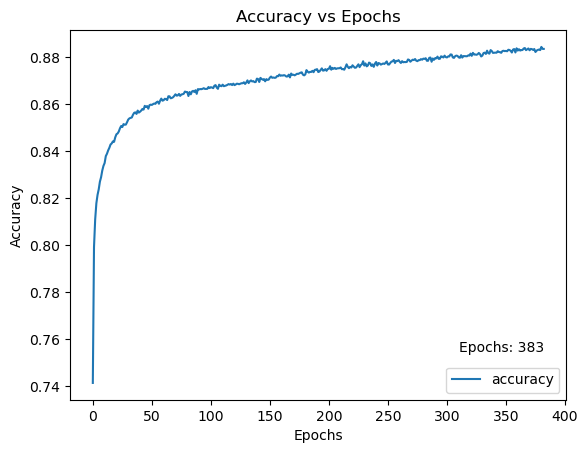

In [174]:
y_accuracy = history_model_rn.history['binary_accuracy']
print(f'Cantidad de epocas: {len(y_accuracy)}')
epochs = range(len(y_accuracy))

plt.plot(epochs, y_accuracy, label='accuracy')
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["accuracy"], loc ="lower right")

# Agregar anotación de la cantidad de épocas
plt.text(0.87, 0.13, f"Epochs: {len(y_accuracy)}", transform=plt.gca().transAxes, horizontalalignment='center')

plt.show()

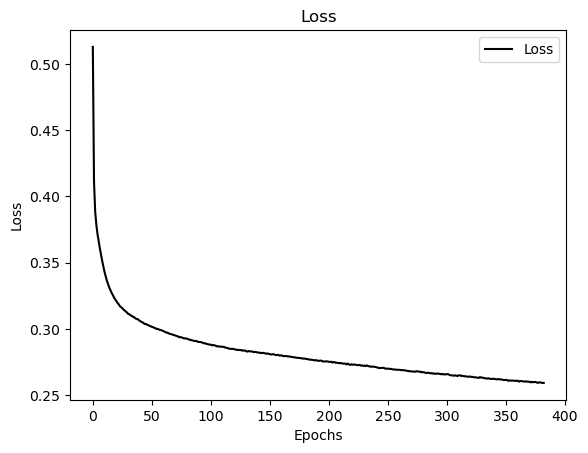

In [175]:
plt.plot(epochs, history_model_rn.history['loss'], color='black', label='Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()

381/381 [==============================] - 0s 823us/step


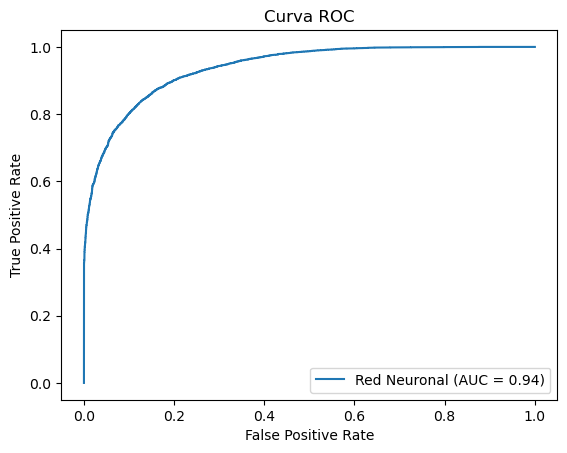

In [176]:
# y_pred = best_tree.predict_proba(x_test)[:, 1]  # obtener las probabilidades para la clase positiva
y_pred = model_rn.predict(x_test_norm)
fpr, tpr, _ = roc_curve(y_test, y_pred) # FPR y TPR son acrónimos de "False Positive Rate" y "True Positive Rate"
roc_auc = roc_auc_score(y_test, y_pred)

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Red Neuronal').plot()
plt.title("Curva ROC")
plt.legend(loc="lower right")  # agregar leyenda en la esquina inferior derecha
plt.show()

#### Buscamos el mejor modelo:

Por cuestiones de tiempo, se decidió no ejecutarlo.

In [177]:
# epochs = [150, 200]
# batches = [10, 15, 20]

# param_grid = dict(epochs=epochs, batch_size=batches)

# print(param_grid)

# model_rn_classifier = KerasClassifier(model=model_rn, random_state=42)

# grid = GridSearchCV(estimator=model_rn_classifier, param_grid=param_grid, n_jobs=-1, cv=5, scoring='f1')
# grid_result = grid.fit(x_train_norm, y_train)

In [178]:
# print("Mejor modelo: %f %s" % (grid_result.best_score_, grid_result.best_params_))

In [179]:
# y_pred_cv = grid.predict(x_test_norm)
# y_pred_cv_flatten = y_pred_cv.flatten().round() # Es un array de 0 y 1 (se redondea para poder calcular la matriz de confusión)
# print(classification_report(y_test, y_pred_cv_flatten))

# # # # Graficar la pérdida y la precisión
# cm = confusion_matrix(y_test, y_pred_cv_flatten)
# sns.heatmap(cm, cmap='Reds',annot=True,fmt='d')
# plt.title("Matriz de confusión - F1 Score")
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

In [180]:
# evaluate_model(model_rn, x_train_norm_array, y_train)

In [181]:
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
# scores = cross_val_score(model_rn, x_train_norm, y_train, scoring='accuracy', cv=cv, verbose=1, n_jobs=-1)

## Aplicación del modelo al dataset de test

##### Lectura del dataset de test preprocesado:

In [182]:
hotel_test = pd.read_csv('./dataset/hotels_test_preprocesado.csv')

##### Lectura del dataset de test original para mantener id:

In [183]:
hotel_test_df = pd.read_csv('./dataset/hotels_test.csv')

##### Predicción y exportación:

In [184]:
x_test_final = hotel_test[features]
x_test_final_cat = x_test_final.drop(cols_to_normalize, axis=1)
x_test_final_norm = stand_scaler.transform(x_test_final[cols_to_normalize])
x_test_final_norm = pd.DataFrame(x_test_final_norm, columns=cols_to_normalize)

In [185]:
y_pred_final = model_rn.predict(pd.concat([x_test_final_norm, x_test_final_cat], axis=1)).flatten().round().astype(int)

830/830 [==============================] - 1s 930us/step


In [186]:
counts = np.bincount(y_pred_final)
count_0 = counts[0]  # Cantidad de elementos 0
count_1 = counts[1]  # Cantidad de elementos 1

print("Resultado de la predicción: ")
print("No cancela:", count_0)
print("Cancela:", count_1)
print("Porceentaje de cancelaciones: {:.2f}%".format(count_1/(count_0+count_1)*100))

Resultado de la predicción: 
No cancela: 13546
Cancela: 12989
Porceentaje de cancelaciones: 48.95%


In [187]:
pd.concat([hotel_test_df['id'],pd.DataFrame(data=y_pred_final, columns=['is_canceled'])], axis=1).to_csv('./predicciones/pred_rn_adadelta_1.csv', index=False)

---

## Exportación del modelo

In [189]:
model_rn.save('./modelos/model_rn_adadelta_1.h5')

In [188]:
# dump(model_rn, open('./modelos/modelo_rn_adadelta_1.pkl', 'wb'))